Load model, test set\
Evaluate accuracy, RMSE, F1, AUC, etc.\
Visualize confusion matrices, residuals, etc.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

from models.acnh_model import ACNHModel

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import joblib
import json

/Users/rainalex/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
X_train, X_test, y_train, y_test = joblib.load('./data/preprocessed/train_test_data.pkl')
config = json.load(open('./models/configs/2025-03-27_00:40:37.json'))
emb_sizes = joblib.load('./data/preprocessed/embedding_sizes.pkl')
preprocessing = joblib.load('./data/preprocessed/preprocessing.pkl')

In [3]:
X_test = torch.LongTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [4]:
torch.manual_seed(2)

In [5]:
model = ACNHModel(1, emb_sizes=emb_sizes, 
                  layers=config['hidden_sizes'], drop_p=config['dropout'])
model.load_state_dict(torch.load('models/versions/model_2025-03-27_00:40:37.pt'))
model.eval()

ACNHModel(
  (embed): ModuleList(
    (0): Embedding(8, 4)
    (1): Embedding(3, 1)
    (2-3): 2 x Embedding(15, 7)
    (4): Embedding(16, 8)
    (5): Embedding(6, 3)
    (6): Embedding(3, 1)
    (7): Embedding(7, 3)
    (8): Embedding(3, 1)
  )
  (embed_drop): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=35, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)

# Prediction Evaluations

In [6]:
with torch.no_grad():
    preds = model(X_test)

In [7]:
criterion = nn.MSELoss()
loss = criterion(preds, y_test)
loss

tensor(0.0230)

In [8]:
preds = preprocessing['label_scaler'].inverse_transform(preds)
y_test = preprocessing['label_scaler'].inverse_transform(y_test)

In [9]:
rows = 100
total_diff = 0
print(f"  {'PRED':8}{'TRUE':8}{'DIFF':8}")
for i in range(rows):
    diff = y_test[i] - preds[i]
    print(f"{np.floor(preds[i]).item():8.2f}{y_test[i].item():8.2f}{diff.item():8.2f}")
    total_diff += diff
print(f"Average difference = {total_diff/rows}")

  PRED    TRUE    DIFF    
  303.00  227.00  -76.04
  470.00  525.00   54.86
  261.00  440.00  178.89
  412.00  400.00  -12.97
  403.00  560.00  156.76
  219.00  275.00   55.40
  273.00  260.00  -13.34
  356.00  220.00 -136.64
  419.00  400.00  -19.48
  493.00  630.00  136.64
  258.00  245.00  -13.01
  503.00  600.00   96.13
  218.00  175.00  -43.08
  255.00  260.00    4.79
  446.00  450.00    3.33
  281.00  180.00 -101.48
  310.00  437.00  126.24
  287.00  240.00  -47.02
  247.00  175.00  -72.86
  263.00  240.00  -23.50
  295.00  275.00  -20.98
  194.00  150.00  -44.39
  394.00  300.00  -94.08
  271.00  250.00  -21.78
  362.00  500.00  137.41
  293.00  200.00  -93.89
  259.00  265.00    5.46
  326.00  330.00    3.25
  312.00  390.00   77.10
  247.00  240.00   -7.66
  301.00  300.00   -1.57
  232.00  140.00  -92.48
  391.00  480.00   88.71
  308.00  390.00   81.99
  475.00  630.00  154.11
  268.00  200.00  -68.82
  275.00  330.00   54.02
  417.00  720.00  302.87
  238.00  400.00  161.2

Text(0.5, 1.0, 'Prediction vs Actual')

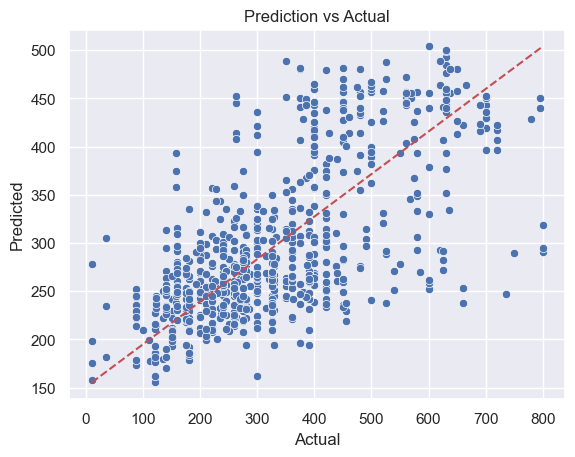

In [10]:
sns.scatterplot(x=y_test.flatten(), y=preds.flatten())
plt.plot([y_test.min(), y_test.max()], [preds.min(), preds.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Prediction vs Actual')

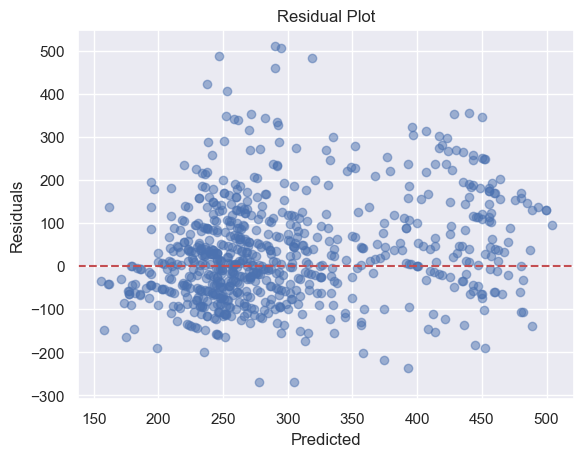

In [11]:
residuals = y_test - preds

plt.scatter(preds, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)
plt.show()

/Users/rainalex/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rainalex/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


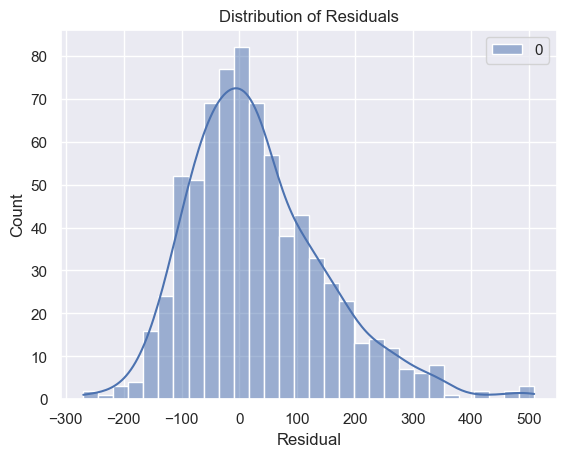

In [12]:
sns.histplot(residuals, bins=30, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.grid(True)
plt.show()

# Looking into predictions by feature
**Category**\
A lot of what was observed in the EDA is reflected in the predictions
- dresses are predicted as being more expensive
- dresses, shoes, and tops, which had the widest distributions all also have the highest residuals

**Style**
- The gorgeous and elegant styles did have relatively wide distributions which again may be influencing the wide prediction range
- During EDA, although the cute did hover around the same prices as the others (excluding gorgeous and elegant), its curve was slightly flatter which may explain its wide prediction range
- overall the residuals are pretty sporadic


In [13]:
def decode_categories(code_tensor, mapping):
    return np.array([mapping[code.item()] for code in code_tensor])

In [14]:
# TODO save category indices - ex. 0 is Category, 7 is Style
clothing_categories = decode_categories(X_test[:,0], preprocessing['category_mappings']['Category_rev'])
clothing_styles = decode_categories(X_test[:,7], preprocessing['category_mappings']['Style_rev'])
clothing_source = decode_categories(X_test[:,4], preprocessing['category_mappings']['Source_rev'])
clothing_season = decode_categories(X_test[:,5], preprocessing['category_mappings']['Seasonal Availability_rev'])

In [15]:
data = {'category': clothing_categories,
        'style': clothing_styles,
        'season': clothing_season,
        'source': clothing_source,
        'true': y_test.flatten(),
        'preds': preds.flatten(),
        'residuals': residuals.flatten()}

eval_df = pd.DataFrame(data)

## Category

Text(0.5, 1.0, 'Category - Residual Plot')

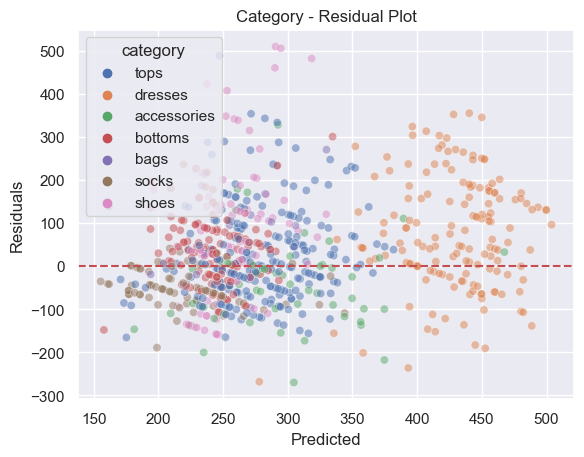

In [16]:
sns.scatterplot(eval_df, x='preds', y='residuals', alpha=0.5, hue='category')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Category - Residual Plot')

<Axes: xlabel='category', ylabel='preds'>

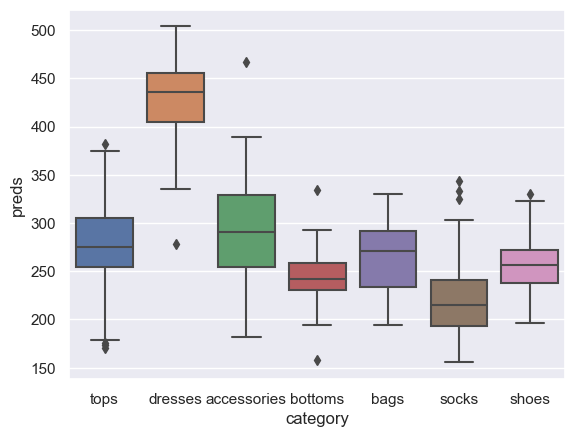

In [17]:
sns.boxplot(eval_df, y='preds', x='category')

In [18]:
eval_df.groupby('category')['residuals'].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
accessories,55.0,-36.756586,102.971847,-269.742410,-99.242631,-41.855033,8.869672,327.596757
bags,17.0,86.247542,144.338145,-96.422933,-19.058717,45.993812,118.577038,487.831238
bottoms,127.0,38.209244,79.178913,-147.923972,-18.724150,37.855454,82.956321,300.350303
dresses,158.0,76.418348,129.888085,-268.002890,-9.185009,64.015903,169.904132,354.756135
shoes,83.0,78.886540,164.325530,-159.258839,-33.513960,57.025462,142.787672,509.465476
socks,78.0,-51.278655,45.615230,-188.934990,-72.704025,-57.044335,-31.137623,138.080922
tops,221.0,22.651655,105.219162,-165.296359,-50.601026,2.287018,75.303048,353.344635


## Style

Text(0.5, 1.0, 'Style - Residual Plot')

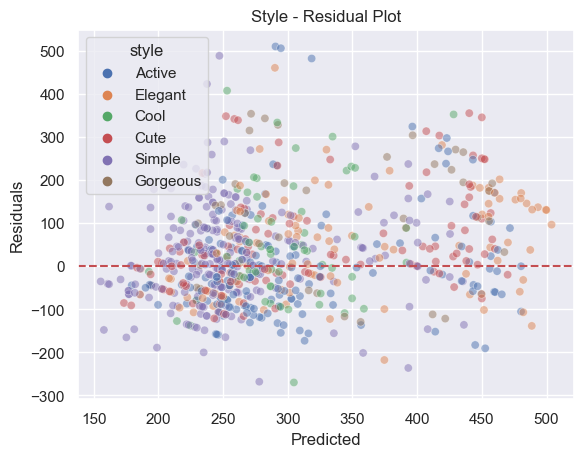

In [19]:
sns.scatterplot(eval_df, x='preds', y='residuals', alpha=0.5, hue='style')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Style - Residual Plot')

In [20]:
eval_df.groupby('style')['residuals'].describe()

,count,mean,std,min,25%,50%,75%,max
style,,,,,,,,
Active,168.0,-4.563631,119.377688,-190.579324,-78.268577,-26.283879,36.926792,509.465476
Cool,65.0,48.556805,130.182671,-269.742410,-26.198898,31.951504,106.968065,406.888867
Cute,121.0,48.917543,115.041153,-121.186516,-25.373756,24.654683,98.630903,354.756135
Elegant,104.0,45.007296,112.372482,-217.646599,-55.594197,41.270679,130.282257,459.920823
Gorgeous,37.0,116.261619,144.420414,-129.343795,2.512977,123.005317,223.442997,353.344635
Simple,244.0,27.189217,108.428171,-268.002890,-43.569185,16.822730,88.407853,487.831238


<Axes: xlabel='style', ylabel='preds'>

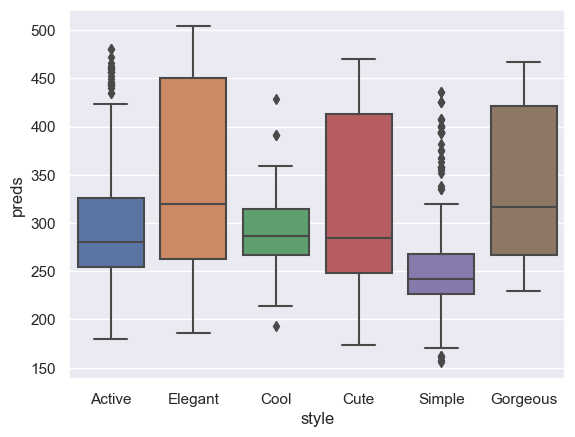

In [21]:
sns.boxplot(eval_df, y='preds', x='style')

# Embedding Analysis
Despite the model not having been trained on any "unknown" category samples, unknown embedding has high similarity with accessories and bags. This may be due to these two having less occurences in the data... Socks and tops are similar, so something is off here...

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

## Category Embeddings

In [23]:
embedding_weights = model.embed[0].weight.data

In [24]:
print([value for idx, value in preprocessing['category_mappings']['Category_rev'].items()])

['accessories', 'bags', 'bottoms', 'dresses', 'shoes', 'socks', 'tops', 'unknown']


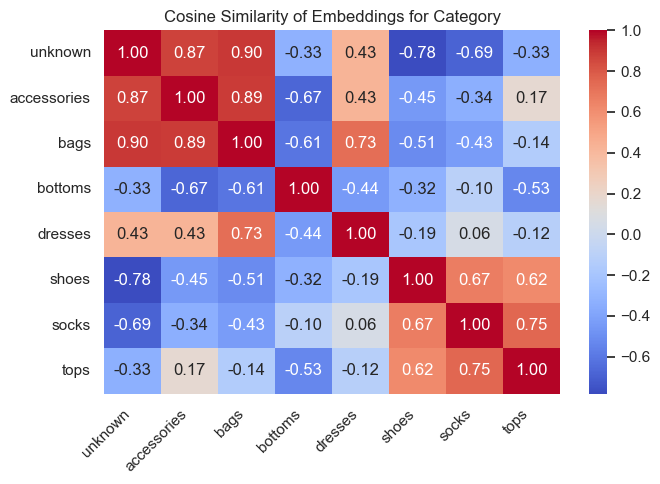

In [25]:
category_values = ['unknown', 'accessories', 'bags', 'bottoms', 'dresses', 'shoes', 'socks', 'tops']
cos_sim_matrix = cosine_similarity(embedding_weights)
cos_sim_df = pd.DataFrame(cos_sim_matrix, index=category_values, columns=category_values)

plt.figure(figsize=(7, 5))
sns.heatmap(cos_sim_df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title(f'Cosine Similarity of Embeddings for Category')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

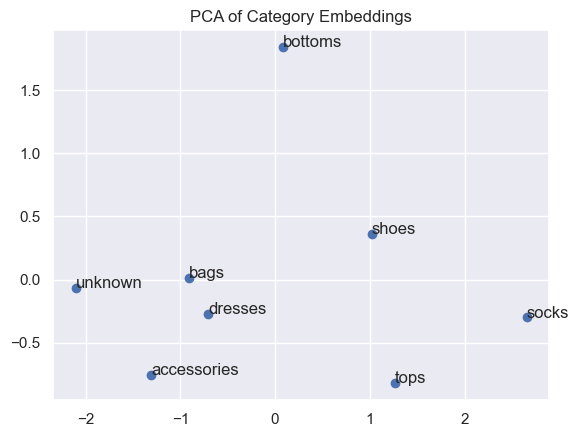

In [26]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2, random_state=2)
embed_2d = pca.fit_transform(embedding_weights)

plt.scatter(embed_2d[:, 0], embed_2d[:, 1])
for i, label in enumerate(category_values):
    plt.annotate(label, (embed_2d[i, 0], embed_2d[i, 1]))
plt.title("PCA of Category Embeddings")
plt.show()

## Training on category embeddings alone
RMSE is around 364 bells. Considering that the Value mean is around 330 bells and the standard deviation in around 160 bells. Performance is poor here so the Category embeddings may not be carrying much signal

In [27]:
embedding_weights = model.embed[0].weight.data.cpu().numpy()
cat_codes_train = X_train[:,0]
cat_codes_test = X_test[:,0]

# Get embedding vector for each value
row_embeddings_train = embedding_weights[cat_codes_train]
row_embeddings_test = embedding_weights[cat_codes_test]

In [28]:
clf = XGBRegressor(n_jobs=4, verbosity=1, random_state=2)
clf.fit(row_embeddings_train, y_train)
y_pred = clf.predict(row_embeddings_test)

print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE: 364.9896776887403


## Training on style embeddings alone


In [29]:
embedding_weights = model.embed[7].weight.data.cpu().numpy()
cat_codes_train = X_train[:,7]
cat_codes_test = X_test[:,7]

# Get embedding vector for each value
row_embeddings_train = embedding_weights[cat_codes_train]
row_embeddings_test = embedding_weights[cat_codes_test]

In [30]:
clf = XGBRegressor(n_jobs=4, verbosity=1, random_state=2)
clf.fit(row_embeddings_train, y_train)
y_pred = clf.predict(row_embeddings_test)

print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE: 365.008011573129
